Libraries needed

In [399]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import numpy as np
import pandas as pd

import re
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shady\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


device(type='cpu')

Preprocessing the tweets

In [373]:
def remove_links_mentions(tweet):
  # Preprocessing the tweets by removing links and mentions
    link_re_pattern = "https?:\/\/t.co/[\w]+"
    mention_re_pattern = "@\w+"
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

Getting train, validation, and test sets

In [641]:
def read_tweets_get_vectors(tweet_file):
    df = pd.read_csv(tweet_file, sep=',', header=0)
    dic_result = {}
    df1 = df[['tweet_id', 'text', 'airline_sentiment']]
    count = 0
    for index in range(len(df1)):
        try:
            label = df.loc[index, "airline_sentiment"]
            tweet_id = df.loc[index, "tweet_id"]
            if label in dic_result:
                dic_result[label][tweet_id] = remove_links_mentions(df.loc[index, "text"])
            else:
                dic_result[label] = {tweet_id: remove_links_mentions(df.loc[index, "text"])}
        except:
            count += 1
    return dic_result


def split_data(twitter_data):
    training = []
    validation = []
    test = []

    for label in twitter_data:
        temp_dic = twitter_data[label]
        lst_tweet_ids = list(temp_dic.keys())
        train_length = int(len(lst_tweet_ids) * 0.8)
        train_ids = lst_tweet_ids[:train_length]
        remaining = lst_tweet_ids[train_length:]
        test_lenght = int(len(remaining) * 0.5)
        test_ids = remaining[:test_lenght]
        validation_id = remaining[test_lenght:]

        for tweet_id in train_ids:
            training.append((label, temp_dic[tweet_id]))
        for tweet_id in validation_id:
            validation.append((label, temp_dic[tweet_id]))
        for tweet_id in test_ids:
            test.append((label, temp_dic[tweet_id]))

    random.shuffle(training)
    random.shuffle(validation)
    random.shuffle(test)
    count = 0
    total_len = 0
    for tuple in training:
        total_len += len(tuple[1].split())
        count += 1
    print(total_len/count)
    count = 0
    total_len = 0
    for tuple in validation:
        total_len += len(tuple[1].split())
        count += 1
    print(total_len/count)
    count = 0
    total_len = 0
    for tuple in test:
        total_len += len(tuple[1].split())
        count += 1
    print(total_len/count)
    return training, validation, test


dic_tweets = read_tweets_get_vectors("Tweets.csv")
training, validation, test = split_data(dic_tweets)

16.40913035931262
16.85912560721721
16.8646773074254


Building Vocabulary of the corpus

In [375]:
index2word = ["<PAD>", "<SOS>", "<EOS>"]

for ds in [training, validation, test]:
    for label, tweet in ds:
        for token in tweet.split(" "):
            if token not in index2word:
                index2word.append(token)

word2index = {token: idx for idx, token in enumerate(index2word)}
len(word2index)

24669

In [642]:
def label_map(label):
    if label == "negative":
        return [1, 0, 0]
    elif label == "neutral":
        return [0, 1, 0]
    else:  # positive
        return [0, 0, 1]

##################
# Seq Length is an important parameter to tune
##################

seq_length = 16 #16

def encode_and_pad(tweet, length):
    sos = [word2index["<SOS>"]]
    eos = [word2index["<EOS>"]]
    pad = [word2index["<PAD>"]]
    tweet_terms = tweet.split(" ")
    if len(tweet_terms) < length - 2:  # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet_terms)
        encoded = [word2index[w] for w in tweet_terms]
        return sos + encoded + eos + pad * n_pads
    else:  # tweet is longer than possible; truncating
        encoded = [word2index[w] for w in tweet_terms]
        truncated = encoded[:length - 2]
        return sos + truncated + eos


train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in training]
validation_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in validation]
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test]

In [691]:
batch_size = 1024 #64

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
validation_x = np.array([tweet for tweet, label in validation_encoded])
validation_y = np.array([label for tweet, label in validation_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validation_ds = TensorDataset(torch.from_numpy(validation_x), torch.from_numpy(validation_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
validation_dl = DataLoader(validation_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [810]:
class LSTM_SentimentAnalysis(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, bidirectional, output, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if not bidirectional:
            self.num_directions = 1
        else:
            self.num_directions = 2
        self.num_layers = num_layers
        self.hidden_size = hidden_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)

        self.dropout = nn.Dropout(dropout)

        self.fc_hidden = nn.Linear(hidden_dim*self.num_directions, hidden_dim)
        self.tanh = nn.Tanh()

        self.fc = nn.Linear(hidden_dim, output)
        
    def forward(self, x, hidden):
        embs = self.embedding(x)

        out, hidden = self.lstm(embs, hidden)

        out = self.dropout(out)
        out = self.fc_hidden(out)
        out = self.tanh(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), dim=-1)
        # out = out[:, -1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        # The LSTM requires two hidden states - one for the hidden state, and one for the cell state.
        return (torch.ones(self.num_layers*self.num_directions, batch_size, self.hidden_size),
                torch.ones(self.num_layers*self.num_directions, batch_size, self.hidden_size))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
41


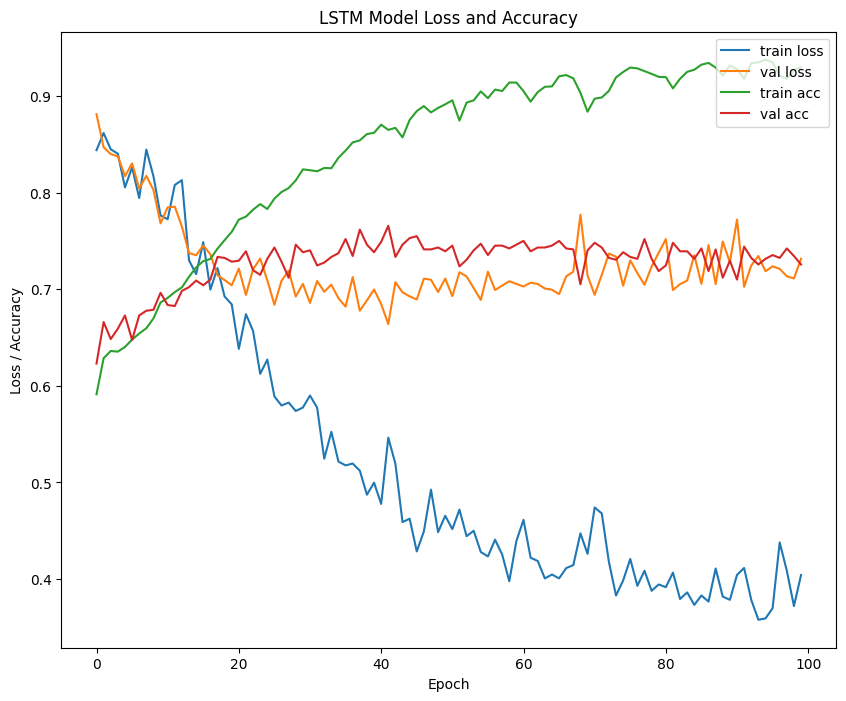

In [854]:
vocab_size = len(word2index)
embedding_dim = 100
num_layers = 1 #3
hidden_dim = 128 #50
output = 3
dropout = 0.5 #.5
bidirectional = True #True
model = LSTM_SentimentAnalysis(vocab_size, embedding_dim, num_layers, hidden_dim, bidirectional, output, dropout)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001) #0.001 0.001

epochs = 100
train_losses = []
train_accs = []  # Add a list to store training accuracies
val_losses = []
val_accs = []
best_epoch = 0
best_acc = 0
best_val = 100
best_model = None
for e in range(epochs):
    print(e)
    h0 = model.init_hidden(batch_size)
    h0 = tuple(h.to(device) for h in h0)
    train_correct = 0
    train_total = 0
    train_acc = 0  # Initialize the training accuracy to 0
    for batch_idx, batch in enumerate(train_dl):
        input = batch[0].to(device)
        target = batch[1].float().to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, h0)
            target = torch.squeeze(target)
            target = torch.max(target, 1)[1]  # convert target to 1D tensor
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()

            # Calculate the accuracy after each training batch
            _, preds = torch.max(out, 1)
            train_correct += torch.sum(preds == target)
            train_total += target.size(0)
            train_acc = train_correct.double() / train_total

    train_losses.append(loss.item())
    train_accs.append(train_acc)  # Append the training accuracy to the list

    val_correct = 0
    val_total = 0
    for batch_idx, batch in enumerate(validation_dl):
        input = batch[0].to(device)
        target = batch[1].float().to(device)
        with torch.set_grad_enabled(False):
            out, hidden = model(input, h0)
            _, preds = torch.max(out, 1)
            target = torch.max(target, 1)[1]  # convert target to 1D tensor
            loss = criterion(out, target)
        val_correct += torch.sum(preds == target)
        val_total += target.size(0)
    val_acc = val_correct.double() / val_total
    val_accs.append(val_acc)
    val_loss = loss.item()
    val_losses.append(val_loss)
    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_epoch = e
        torch.save(best_model.state_dict(), 'best_model.pth')
    #if val_loss < best_val:
    #    best_val = val_loss
    #    best_model = model
    #    best_epoch = e
    #    torch.save(best_model.state_dict(), 'best_model.pth')


best_model = LSTM_SentimentAnalysis(vocab_size, embedding_dim, num_layers, hidden_dim, bidirectional, output, dropout)
best_model.load_state_dict(torch.load('best_model.pth'))
best_model = best_model.to(device)
print(best_epoch)
plt.figure(figsize=(10, 8))
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(train_accs)  
plt.plot(val_accs)
plt.title('LSTM Model Loss and Accuracy')
plt.ylabel('Loss / Accuracy')
plt.xlabel('Epoch')
plt.legend(['train loss', 'val loss', 'train acc', 'val acc'], loc='upper right')
plt.show()


In [868]:
batch_acc = []

for batch_idx, batch in enumerate(test_dl):
    input = batch[0].to(device)
    target = batch[1].to(device)
    with torch.set_grad_enabled(False):
        out, hidden = best_model(input, h0)
        target = target.argmax (dim = 1)
        preds = out.argmax(dim=1)
        batch_acc.append(accuracy_score(preds, target)) 
acc = sum(batch_acc) / len(batch_acc)

print(acc)


0.75
